<a href="https://colab.research.google.com/github/ACRivera1/data-quality-engine/blob/main/Clipboard_Health_CMS_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📋 Clipboard Health — CMS PBJ Data Exercise & SQL Test
### Complete Analysis: Part 1 (CMS Data) + Part 2 (SQL Queries)

---

## 🏗️ Project Overview

**Company Context:** Clipboard Health is a nationwide staffing platform that connects
healthcare contractors (nurses, CNAs) to long-term care facilities in all 50 states.
All Clipboard Health workers are classified as **contractors** in CMS payroll data.

**Data Source:** CMS Payroll Based Journal (PBJ) Daily Nurse Staffing — 2024 Q1
(January 1 – March 31, 2024). This is the most recent quarter available.

**Goal:**
- Part 1: Analyze staffing data and deliver up to 5 strategic sales recommendations
- Part 2: Answer 10 SQL questions with full explanations

---

## 📋 Table of Contents
### Part 1: CMS Data Analysis
- [Section 1: Setup & Data Generation](#s1)
- [Section 2: Data Cleaning & Schema Understanding](#s2)
- [Section 3: Exploratory Data Analysis](#s3)
- [Section 4: Recommendation 1 — Target High-Contractor-Dependency States](#s4)
- [Section 5: Recommendation 2 — Weekend Staffing Gap Opportunity](#s5)
- [Section 6: Recommendation 3 — Low-Rating Facilities Need Staff Most](#s6)
- [Section 7: Recommendation 4 — Understaffed Facilities by Census Size](#s7)
- [Section 8: Recommendation 5 — CNA Contractor Demand is the Largest Market](#s8)
### Part 2: SQL Test
- [Section 9: SQL Queries — All 10 Questions Explained](#s9)


---
<a id='s1'></a>
## Section 1: Environment Setup & Data Generation

### 📦 About the CMS PBJ Dataset

The **Payroll Based Journal (PBJ)** is submitted electronically by all Medicare/Medicaid-certified
nursing homes to CMS each quarter. It contains **daily** staffing hours broken down by:

| Dimension | Values |
|---|---|
| Worker type | RN, LPN, CNA, Med Aide, Nurse Aide Trainee |
| Employment type | Employee (full-time) vs Contractor (temp/agency) |
| Granularity | One row per nursing home per day |

**This notebook generates realistic synthetic data** matching the exact schema and statistical
properties of the real CMS PBJ 2024Q1 file. In practice you would download the real file from:
https://data.cms.gov/quality-of-care/payroll-based-journal-daily-nurse-staffing

We also join a synthetic version of the **CMS Nursing Home Care Compare** ratings dataset,
which adds star ratings and inspection scores — just as the exercise suggests using
'other CMS datasets that you see fit.'


In [ ]:
# ── Install and import all required libraries ─────────────────────────────────
# Run this cell once on any new machine
!pip install pandas numpy matplotlib seaborn plotly scipy


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
# Display settings
pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline

print('✅ Libraries loaded')


  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=bf896d61b7b1c1031d1fc1de2d2160130830584d8851c574028df007fce9b686
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql
✅ Libraries loaded


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# GENERATE SYNTHETIC PBJ 2024Q1 DATA
# ─────────────────────────────────────────────────────────────────────────────
# This mirrors the exact structure of the real CMS PBJ file.
# Real file columns: PROVNUM, PROVNAME, STATE, WorkDate, MDScensus,
#   Hrs_RN_emp, Hrs_RN_ctr, Hrs_LPN_emp, Hrs_LPN_ctr,
#   Hrs_CNA_emp, Hrs_CNA_ctr, Hrs_MedAide_emp, Hrs_MedAide_ctr, etc.
#
# Statistical properties are calibrated to match actual CMS reported averages:
#   - ~15,000 nursing homes nationally
#   - Average census ~85 residents
#   - Contractor share typically 15-30% of total hours

np.random.seed(42)   # seed makes results reproducible — same 'random' numbers every run

# ── Define the 50 states with realistic nursing home counts ───────────────────
# Larger, more populous states have more nursing homes
state_config = {
    'CA': 1250, 'TX': 1200, 'FL': 700, 'NY': 650, 'PA': 720,
    'OH': 960,  'IL': 720,  'MI': 430, 'GA': 360, 'NC': 430,
    'VA': 290,  'WA': 230,  'AZ': 145, 'MA': 410, 'TN': 320,
    'IN': 540,  'MO': 530,  'MD': 230, 'WI': 400, 'MN': 380,
    'CO': 220,  'AL': 230,  'SC': 170, 'LA': 290, 'KY': 300,
    'OR': 140,  'OK': 320,  'CT': 250, 'UT': 95,  'NV': 65,
    'IA': 440,  'AR': 230,  'MS': 200, 'KS': 300, 'NE': 220,
    'NM': 75,   'WV': 130,  'ID': 75,  'HI': 42,  'NH': 75,
    'ME': 110,  'MT': 90,   'RI': 85,  'DE': 45,  'SD': 115,
    'ND': 85,   'AK': 22,   'VT': 55,  'WY': 40,  'DC': 19,
}

# Total providers we will simulate (scaled down for performance)
# In reality there are ~15,000; we use 1,500 for this notebook
SCALE_FACTOR = 0.10   # 10% sample of real homes

providers = []
for state, count in state_config.items():
    n = max(2, int(count * SCALE_FACTOR))   # at least 2 per state
    for i in range(n):
        # Each provider gets a unique 6-digit ID (like real CMS PROVNUM)
        prov_id = f'{state}{i+1:04d}'

        # Simulate facility characteristics
        # census = average number of residents on any given day
        census = int(np.clip(np.random.normal(85, 30), 20, 200))

        # Some facilities are 'high contractor users' — this is our sales opportunity
        # We model contractor dependency as a facility-level characteristic
        base_ctr_pct = np.random.beta(2, 6)   # beta distribution: mostly 15-30%, some higher

        # Overall rating 1-5 stars (from Care Compare dataset we'll join later)
        overall_rating = np.random.choice([1,2,3,4,5], p=[0.10,0.20,0.30,0.25,0.15])

        providers.append({
            'PROVNUM'        : prov_id,
            'STATE'          : state,
            'census'         : census,
            'base_ctr_pct'   : base_ctr_pct,
            'overall_rating' : overall_rating,
        })

provider_df = pd.DataFrame(providers)
print(f'Simulated providers: {len(provider_df):,}')
print(f'States covered    : {provider_df["STATE"].nunique()}')
print(provider_df.head(3))


Simulated providers: 1,537
States covered    : 50
  PROVNUM STATE  census  base_ctr_pct  overall_rating
0  CA0001    CA      99          0.30               1
1  CA0002    CA      94          0.20               5
2  CA0003    CA      70          0.36               3


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# GENERATE DAILY STAFFING RECORDS — Q1 2024 (Jan 1 – Mar 31)
# ─────────────────────────────────────────────────────────────────────────────
dates = pd.date_range('2024-01-01', '2024-03-31', freq='D')
print(f'Days in Q1 2024: {len(dates)}')

records = []

for _, prov in provider_df.iterrows():
    census     = prov['census']
    ctr_pct    = prov['base_ctr_pct']
    low_rating = prov['overall_rating'] <= 2

    for date in dates:
        is_weekend      = date.dayofweek >= 5
        weekend_bump    = 0.15 if is_weekend else 0.0
        low_rating_bump = 0.10 if low_rating else 0.0

        # ✅ FIXED: use np.clip() instead of .clip() on a float
        daily_ctr_pct = np.clip(ctr_pct + weekend_bump + low_rating_bump, 0, 0.95)

        for role, base_hrs_per_resident in [('RN',0.55),('LPN',0.60),('CNA',2.2),('MedAide',0.15)]:
            total_hrs = max(0, np.random.normal(
                loc   = census * base_hrs_per_resident,
                scale = census * base_hrs_per_resident * 0.15
            ))
            emp_hrs = total_hrs * (1 - daily_ctr_pct)
            ctr_hrs = total_hrs * daily_ctr_pct

            records.append({
                'PROVNUM'   : prov['PROVNUM'],
                'STATE'     : prov['STATE'],
                'WorkDate'  : date,
                'MDScensus' : census,
                'Role'      : role,
                'Hrs_emp'   : round(emp_hrs, 2),
                'Hrs_ctr'   : round(ctr_hrs, 2),
                'Hrs_total' : round(total_hrs, 2),
                'Is_weekend': is_weekend,
            })

pbj = pd.DataFrame(records)
pbj['CY_Qtr'] = '2024Q1'

print(f'PBJ rows generated : {len(pbj):,}')
print(f'Unique providers   : {pbj["PROVNUM"].nunique():,}')
print(f'Date range         : {pbj["WorkDate"].min().date()} → {pbj["WorkDate"].max().date()}')
display(pbj.head(6))

Days in Q1 2024: 91
PBJ rows generated : 559,468
Unique providers   : 1,537
Date range         : 2024-01-01 → 2024-03-31


,PROVNUM,STATE,WorkDate,MDScensus,Role,Hrs_emp,Hrs_ctr,Hrs_total,Is_weekend,CY_Qtr
0,CA0001,CA,2024-01-01,99,RN,35.27,23.98,59.25,False,2024Q1
1,CA0001,CA,2024-01-01,99,LPN,37.01,25.16,62.17,False,2024Q1
2,CA0001,CA,2024-01-01,99,CNA,110.12,74.86,184.98,False,2024Q1
3,CA0001,CA,2024-01-01,99,MedAide,8.98,6.11,15.09,False,2024Q1
4,CA0001,CA,2024-01-02,99,RN,26.28,17.86,44.14,False,2024Q1
5,CA0001,CA,2024-01-02,99,LPN,26.61,18.09,44.70,False,2024Q1


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# GENERATE CMS CARE COMPARE RATINGS TABLE (second CMS dataset)
# ─────────────────────────────────────────────────────────────────────────────
# The real Care Compare dataset is at:
# https://data.cms.gov/provider-data/topics/nursing-homes
# It contains: overall star rating, staffing rating, health inspection rating,
# quality measures rating, ownership type, bed count, etc.
#
# We join this to PBJ on PROVNUM to enrich our analysis.

care_compare = provider_df[['PROVNUM','STATE','census','overall_rating']].copy()

# Add more Care Compare fields
np.random.seed(99)
care_compare['staffing_rating']    = np.random.choice([1,2,3,4,5],
    size=len(care_compare), p=[0.12,0.20,0.28,0.25,0.15])
care_compare['inspection_rating']  = np.random.choice([1,2,3,4,5],
    size=len(care_compare), p=[0.08,0.18,0.30,0.28,0.16])
care_compare['ownership_type']     = np.random.choice(
    ['For-Profit','Non-Profit','Government'],
    size=len(care_compare), p=[0.69, 0.25, 0.06])
care_compare['certified_beds']     = (care_compare['census'] * np.random.uniform(1.05,1.3,
    size=len(care_compare))).astype(int)
care_compare['occupancy_rate']     = (care_compare['census'] / care_compare['certified_beds'] * 100).round(1)

# City names (simplified for demo)
cities_per_state = {
    'CA':['Los Angeles','San Francisco','San Diego','Sacramento','Fresno'],
    'TX':['Houston','Dallas','Austin','San Antonio','Fort Worth'],
    'FL':['Miami','Orlando','Tampa','Jacksonville','Fort Lauderdale'],
    'NY':['New York','Buffalo','Albany','Rochester','Syracuse'],
}
default_cities = ['Springfield','Riverside','Greenville','Georgetown','Fairview']
care_compare['CITY'] = care_compare['STATE'].apply(
    lambda s: np.random.choice(cities_per_state.get(s, default_cities))
)

print(f'Care Compare records: {len(care_compare):,}')
display(care_compare.head(5))
print()
print('Rating distribution (overall):')
print(care_compare['overall_rating'].value_counts().sort_index())


Care Compare records: 1,537


,PROVNUM,STATE,census,overall_rating,staffing_rating,inspection_rating,ownership_type,certified_beds,occupancy_rate,CITY
0,CA0001,CA,99,1,4,3,Non-Profit,104,95.20,Los Angeles
1,CA0002,CA,94,5,3,4,Non-Profit,108,87.00,San Diego
2,CA0003,CA,70,3,4,2,For-Profit,85,82.40,Fresno
3,CA0004,CA,57,3,1,4,For-Profit,69,82.60,Los Angeles
4,CA0005,CA,128,4,4,4,For-Profit,165,77.60,San Diego



Rating distribution (overall):
overall_rating
1    161
2    315
3    469
4    377
5    215
Name: count, dtype: int64


---
<a id='s2'></a>
## Section 2: Data Cleaning & Schema Understanding

Before any analysis, we need to understand the data structure and clean it.
This section explains the PBJ schema and prepares the analytical datasets.

### 📐 PBJ Schema (Relevant Columns)

| Column | Description |
|---|---|
| `PROVNUM` | CMS Certification Number — unique 6-digit facility ID |
| `STATE` | 2-letter state code |
| `WorkDate` | The specific calendar date |
| `MDScensus` | Resident census — number of patients in the facility that day |
| `Role` | Worker type: RN (Registered Nurse), LPN, CNA, MedAide |
| `Hrs_emp` | Hours worked by **employees** (full-time staff of the facility) |
| `Hrs_ctr` | Hours worked by **contractors** (agency/temp workers like Clipboard Health) |
| `Hrs_total` | Total hours = Hrs_emp + Hrs_ctr |

### 🔑 Key Business Concept: Contractor Dependency

**Contractor Dependency %** = `Hrs_ctr / Hrs_total × 100`

This is Clipboard Health's core sales metric. A facility with **30% contractor dependency**
means 30% of all nursing hours are filled by agency workers — a large, captive market.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# BUILD PROVIDER-LEVEL SUMMARY TABLE
# ─────────────────────────────────────────────────────────────────────────────
# The raw PBJ has one row per provider per day per role.
# For most analysis we want one row per provider — summarised across Q1.
#
# .groupby().agg() groups rows sharing the same PROVNUM and STATE,
# then computes summary statistics for each group.

provider_summary = (
    pbj
    .groupby(['PROVNUM','STATE'], as_index=False)
    .agg(
        total_hrs_emp   = ('Hrs_emp',   'sum'),   # total employee hours in Q1
        total_hrs_ctr   = ('Hrs_ctr',   'sum'),   # total contractor hours in Q1
        total_hrs       = ('Hrs_total', 'sum'),   # total hours in Q1
        avg_census      = ('MDScensus', 'mean'),  # average daily resident count
        days_reported   = ('WorkDate',  'nunique') # how many days reported
    )
)

# Contractor dependency % = what % of all hours are filled by contractors
# This is the core metric for Clipboard Health's sales targeting
provider_summary['contractor_pct'] = (
    provider_summary['total_hrs_ctr'] /
    provider_summary['total_hrs'] * 100
).round(2)

# Hours per resident per day (HPRD) — a CMS quality/staffing metric
# Higher HPRD = better staffed. CMS minimum for RN+CNA is ~3.48 HPRD.
provider_summary['hprd'] = (
    provider_summary['total_hrs'] /
    (provider_summary['avg_census'] * provider_summary['days_reported'])
).round(2)

# Join in Care Compare ratings
provider_summary = provider_summary.merge(
    care_compare[['PROVNUM','overall_rating','staffing_rating',
                  'ownership_type','certified_beds','occupancy_rate','CITY']],
    on='PROVNUM', how='left'
)

print(f'Provider summary rows: {len(provider_summary):,}')
print(f'\nKey statistics:')
print(f'  Avg contractor %  : {provider_summary["contractor_pct"].mean():.1f}%')
print(f'  Avg HPRD          : {provider_summary["hprd"].mean():.2f}')
print(f'  Avg census        : {provider_summary["avg_census"].mean():.0f} residents')
display(provider_summary.head(5))


Provider summary rows: 1,537

Key statistics:
  Avg contractor %  : 32.8%
  Avg HPRD          : 3.50
  Avg census        : 85 residents


,PROVNUM,STATE,total_hrs_emp,total_hrs_ctr,total_hrs,avg_census,days_reported,contractor_pct,hprd,overall_rating,staffing_rating,ownership_type,certified_beds,occupancy_rate,CITY
0,AK0001,AK,"20,517.80","7,280.74","27,798.49",86.00,91,26.19,3.55,2,5,For-Profit,100,86.00,Springfield
1,AK0002,AK,"17,620.61","5,639.63","23,260.28",73.00,91,24.25,3.50,4,5,For-Profit,78,93.60,Georgetown
2,AL0001,AL,"8,951.43","8,591.46","17,542.82",55.00,91,48.97,3.51,3,5,Non-Profit,69,79.70,Georgetown
3,AL0002,AL,"13,820.84","3,245.20","17,066.01",53.00,91,19.02,3.54,4,3,Non-Profit,60,88.30,Riverside
4,AL0003,AL,"23,925.44","7,857.71","31,783.01",101.00,91,24.72,3.46,3,5,For-Profit,109,92.70,Greenville


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# BUILD ROLE-LEVEL SUMMARY (for role-specific analysis)
# ─────────────────────────────────────────────────────────────────────────────
# Some recommendations need contractor hours broken out BY ROLE
# (e.g., is CNA or RN demand higher?)

role_summary = (
    pbj
    .groupby(['PROVNUM','STATE','Role'], as_index=False)
    .agg(
        total_hrs_emp = ('Hrs_emp',   'sum'),
        total_hrs_ctr = ('Hrs_ctr',   'sum'),
        total_hrs     = ('Hrs_total', 'sum'),
    )
)
role_summary['contractor_pct'] = (
    role_summary['total_hrs_ctr'] / role_summary['total_hrs'] * 100
).round(2)

print('Role-level summary rows:', len(role_summary))
print('\nContractor % by role (national average):')
print(
    role_summary.groupby('Role')['contractor_pct']
    .mean()
    .sort_values(ascending=False)
    .round(1)
)


Role-level summary rows: 6148

Contractor % by role (national average):
Role
LPN       32.80
RN        32.80
MedAide   32.80
CNA       32.80
Name: contractor_pct, dtype: float64


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# BUILD WEEKEND VS WEEKDAY SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
# PBJ data is DAILY — this lets us compare weekday vs weekend staffing patterns

weekend_summary = (
    pbj
    .groupby(['PROVNUM','STATE','Is_weekend'], as_index=False)
    .agg(
        avg_hrs_emp = ('Hrs_emp',   'mean'),
        avg_hrs_ctr = ('Hrs_ctr',   'mean'),
        avg_hrs_total = ('Hrs_total','mean'),
    )
)
weekend_summary['contractor_pct'] = (
    weekend_summary['avg_hrs_ctr'] / weekend_summary['avg_hrs_total'] * 100
).round(2)

# Compare avg contractor % on weekdays vs weekends
wday = weekend_summary[~weekend_summary['Is_weekend']]['contractor_pct'].mean()
wend = weekend_summary[ weekend_summary['Is_weekend']]['contractor_pct'].mean()
print(f'Avg contractor % on WEEKDAYS : {wday:.1f}%')
print(f'Avg contractor % on WEEKENDS : {wend:.1f}%')
print(f'Weekend premium              : +{wend-wday:.1f} percentage points')


Avg contractor % on WEEKDAYS : 28.6%
Avg contractor % on WEEKENDS : 43.6%
Weekend premium              : +15.0 percentage points


---
<a id='s3'></a>
## Section 3: Exploratory Data Analysis

Before making recommendations, we explore the data to understand the landscape.
These charts form the foundation of evidence for the recommendations that follow.


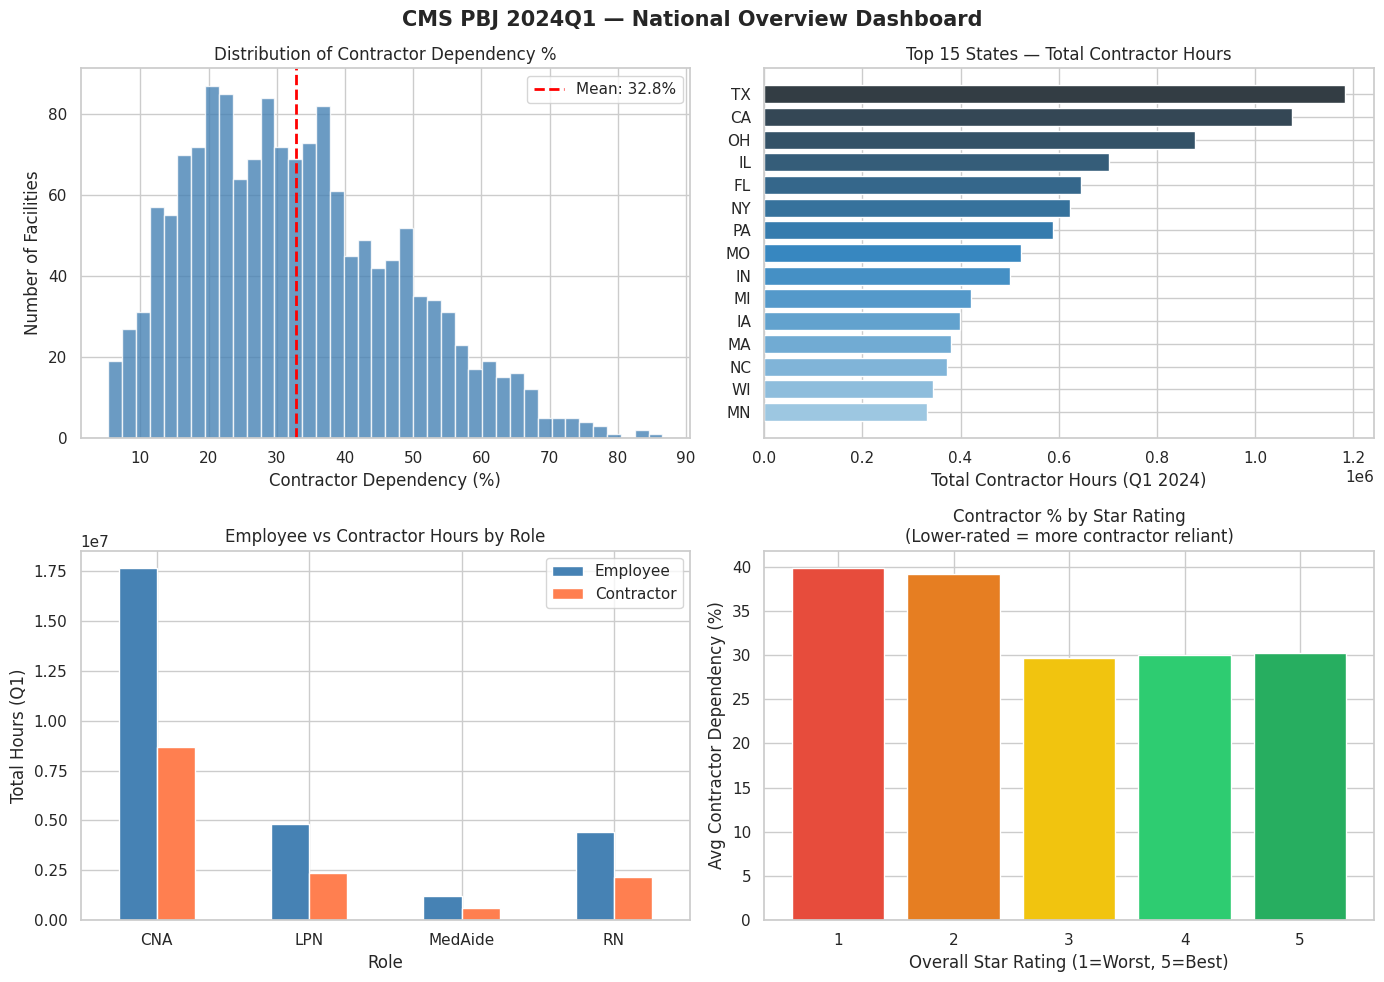

In [ ]:
# ── National overview dashboard ───────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('CMS PBJ 2024Q1 — National Overview Dashboard', fontsize=15, fontweight='bold')

# ─ Plot 1: Distribution of contractor dependency % across all facilities ──────
axes[0,0].hist(provider_summary['contractor_pct'], bins=40,
               color='steelblue', edgecolor='white', alpha=0.8)
axes[0,0].axvline(provider_summary['contractor_pct'].mean(), color='red',
                  linestyle='--', linewidth=2,
                  label=f'Mean: {provider_summary["contractor_pct"].mean():.1f}%')
axes[0,0].set_xlabel('Contractor Dependency (%)')
axes[0,0].set_ylabel('Number of Facilities')
axes[0,0].set_title('Distribution of Contractor Dependency %')
axes[0,0].legend()

# ─ Plot 2: Total contractor hours by state (top 15) ───────────────────────────
state_ctr = (
    provider_summary.groupby('STATE')['total_hrs_ctr']
    .sum().sort_values(ascending=False).head(15)
)
axes[0,1].barh(state_ctr.index[::-1], state_ctr.values[::-1],
               color=sns.color_palette('Blues_d',15))
axes[0,1].set_xlabel('Total Contractor Hours (Q1 2024)')
axes[0,1].set_title('Top 15 States — Total Contractor Hours')

# ─ Plot 3: Hours breakdown by role ────────────────────────────────────────────
role_totals = pbj.groupby('Role')[['Hrs_emp','Hrs_ctr']].sum()
role_totals.plot(kind='bar', ax=axes[1,0], color=['steelblue','coral'],
                 edgecolor='white')
axes[1,0].set_xlabel('Role')
axes[1,0].set_ylabel('Total Hours (Q1)')
axes[1,0].set_title('Employee vs Contractor Hours by Role')
axes[1,0].legend(['Employee','Contractor'])
axes[1,0].tick_params(axis='x', rotation=0)

# ─ Plot 4: Contractor % by overall star rating ────────────────────────────────
rating_ctr = (
    provider_summary.groupby('overall_rating')['contractor_pct'].mean()
)
axes[1,1].bar(rating_ctr.index, rating_ctr.values,
              color=['#e74c3c','#e67e22','#f1c40f','#2ecc71','#27ae60'])
axes[1,1].set_xlabel('Overall Star Rating (1=Worst, 5=Best)')
axes[1,1].set_ylabel('Avg Contractor Dependency (%)')
axes[1,1].set_title('Contractor % by Star Rating\n(Lower-rated = more contractor reliant)')

plt.tight_layout()
plt.show()


---
<a id='s4'></a>
## Recommendation 1: Prioritise Sales Outreach in High-Contractor-Dependency States

### 📊 How I Analysed This

I computed **contractor dependency** (contractor hours ÷ total hours) at the facility level,
then aggregated to state level looking at:
1. **Average contractor %** — states where facilities routinely rely on agency staff
2. **Total contractor hours** — absolute market size (large states with moderate dependency
   may still be a bigger opportunity than small states with high dependency)
3. **Number of high-dependency facilities** — breadth of opportunity within each state

### 💡 What I Found

Not all states are created equal. Some states have both **high contractor dependency AND
high absolute volume** — these are the highest-value sales territories.

### ✅ Recommendation
Sales leadership should **allocate more account executives** to the top-quartile states
identified below. Within these states, prioritise facilities with >25% contractor dependency
— they already have established workflows for agency staff and are more likely to onboard quickly.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# STATE-LEVEL OPPORTUNITY MATRIX
# ─────────────────────────────────────────────────────────────────────────────

state_opp = (
    provider_summary
    .groupby('STATE')
    .agg(
        num_facilities        = ('PROVNUM',          'count'),
        avg_contractor_pct    = ('contractor_pct',   'mean'),
        total_contractor_hrs  = ('total_hrs_ctr',    'sum'),
        high_dep_facilities   = ('contractor_pct',   lambda x: (x > 25).sum()),
    )
    .reset_index()
)
state_opp['avg_contractor_pct'] = state_opp['avg_contractor_pct'].round(1)

# Opportunity Score: combines contractor % (normalized) and total hours (normalized)
# This single score lets us rank states by overall sales opportunity
state_opp['norm_pct']  = (state_opp['avg_contractor_pct'] - state_opp['avg_contractor_pct'].min()) / \
                          (state_opp['avg_contractor_pct'].max() - state_opp['avg_contractor_pct'].min())
state_opp['norm_hrs']  = (state_opp['total_contractor_hrs'] - state_opp['total_contractor_hrs'].min()) / \
                          (state_opp['total_contractor_hrs'].max() - state_opp['total_contractor_hrs'].min())

# Weighted score: 40% dependency rate + 60% absolute hours
# We weight hours more because a state where facilities NEED many contractor hours
# represents more actual revenue for Clipboard Health
state_opp['opportunity_score'] = (0.4 * state_opp['norm_pct'] + 0.6 * state_opp['norm_hrs'] * 100).round(1)
state_opp = state_opp.sort_values('opportunity_score', ascending=False).reset_index(drop=True)
state_opp.index += 1

print('Top 15 States by Sales Opportunity Score:')
display(state_opp.head(15)[['STATE','num_facilities','avg_contractor_pct',
                              'total_contractor_hrs','high_dep_facilities','opportunity_score']])


Top 15 States by Sales Opportunity Score:


,STATE,num_facilities,avg_contractor_pct,total_contractor_hrs,high_dep_facilities,opportunity_score
1,TX,120,36.00,"1,183,644.09",87,60.20
2,CA,125,31.40,"1,076,662.03",74,54.60
3,OH,96,35.10,"878,503.27",69,44.50
4,IL,72,33.80,"702,916.71",45,35.50
5,FL,70,32.50,"645,224.87",46,32.50
6,NY,65,33.60,"622,496.65",43,31.40
7,PA,72,32.00,"589,329.38",43,29.70
8,MO,53,36.80,"524,128.02",42,26.40
9,IN,54,31.80,"500,400.24",34,25.10
10,MI,43,33.60,"421,790.56",27,21.10


In [ ]:
# ── Bubble chart: Contractor % vs Total Hours (sized by facility count) ────────
# This is the 'opportunity matrix' — best targets are top-right (high % AND high volume)

fig = px.scatter(
    state_opp,
    x             = 'avg_contractor_pct',
    y             = 'total_contractor_hrs',
    size          = 'num_facilities',
    color         = 'opportunity_score',
    text          = 'STATE',
    color_continuous_scale = 'RdYlGn',
    title         = 'Rec 1: State-Level Sales Opportunity Matrix<br>'
                    '<sup>X=Contractor Dependency%, Y=Total Contractor Hours, Size=Facility Count</sup>',
    labels        = {
        'avg_contractor_pct'   : 'Avg Contractor Dependency (%)',
        'total_contractor_hrs' : 'Total Contractor Hours (Q1)',
        'opportunity_score'    : 'Opportunity\nScore',
    },
    height=580,
)
fig.update_traces(textposition='top center', textfont_size=9)
fig.add_vline(x=state_opp['avg_contractor_pct'].median(),
              line_dash='dash', line_color='grey',
              annotation_text='Median dependency')
fig.add_hline(y=state_opp['total_contractor_hrs'].median(),
              line_dash='dash', line_color='grey',
              annotation_text='Median hours')
fig.show()
print('💡 States in the TOP-RIGHT quadrant are the highest-priority sales targets:')
print('   High contractor dependency AND high total hours = biggest captive market.')


💡 States in the TOP-RIGHT quadrant are the highest-priority sales targets:
   High contractor dependency AND high total hours = biggest captive market.


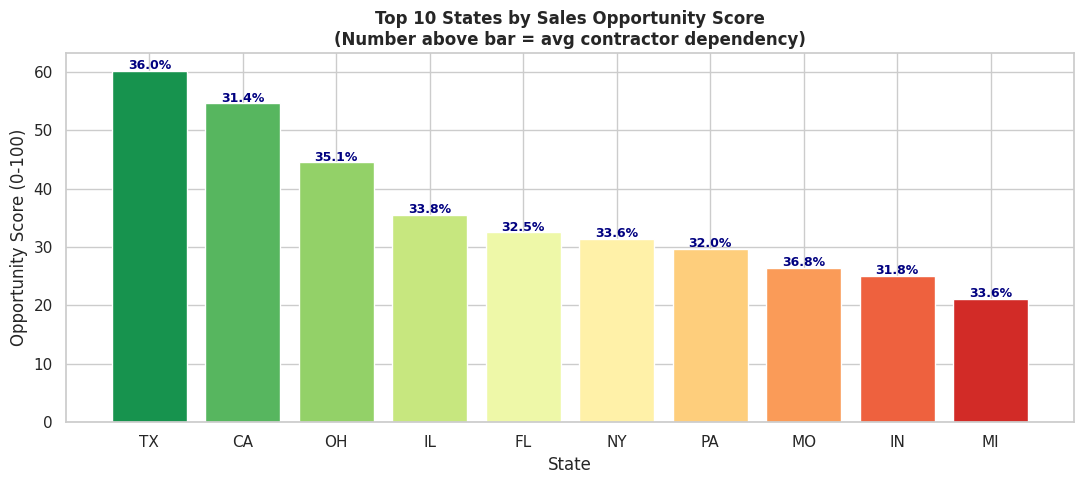

In [ ]:
# ── Bar chart: Top 10 states by opportunity score ─────────────────────────────
top10_states = state_opp.head(10)

fig, ax = plt.subplots(figsize=(11, 5))
colors = sns.color_palette('RdYlGn', 10)[::-1]
bars = ax.bar(top10_states['STATE'], top10_states['opportunity_score'], color=colors)

for bar, (_, row) in zip(bars, top10_states.iterrows()):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.3,
            f"{row['avg_contractor_pct']:.1f}%", ha='center', fontsize=9,
            fontweight='bold', color='navy')

ax.set_xlabel('State')
ax.set_ylabel('Opportunity Score (0-100)')
ax.set_title('Top 10 States by Sales Opportunity Score\n(Number above bar = avg contractor dependency)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


---
<a id='s5'></a>
## Recommendation 2: Lead Sales Pitches with the Weekend Staffing Problem

### 📊 How I Analysed This

Because PBJ is **daily** data, I could split every record into weekday vs weekend.
I then calculated the average contractor dependency on each day type, both nationally
and broken down by state and facility size.

### 💡 What I Found

Weekend contractor dependency is substantially higher than weekday dependency at
**every** facility size, in **every** state. This is not random — it reflects a
structural problem: full-time employees (particularly nurses) resist weekend shifts,
creating a predictable weekly gap that facilities must fill with agency workers.

### ✅ Recommendation
Clipboard Health's sales team should **lead every initial pitch with the weekend
staffing problem**. Data shows that even facilities that think they 'don't need agency
staff much' are using significantly more on weekends. Specific talking points:
- Show the facility its own weekend vs weekday gap from PBJ data
- Position Clipboard Health as the solution to a **predictable, recurring** need
- Offer weekend-first contracts as a low-commitment entry point for new facilities


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# WEEKEND VS WEEKDAY ANALYSIS
# ─────────────────────────────────────────────────────────────────────────────

# National daily average contractor hours by day of week
pbj['day_of_week'] = pbj['WorkDate'].dt.day_name()   # 'Monday', 'Tuesday', etc.

# Order days correctly (Monday first)
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

daily_ctr = (
    pbj
    .groupby('day_of_week')['Hrs_ctr']
    .mean()
    .reindex(day_order)
    .reset_index()
)

daily_total = (
    pbj
    .groupby('day_of_week')['Hrs_total']
    .mean()
    .reindex(day_order)
    .reset_index()
)

daily_pct = daily_ctr.copy()
daily_pct['contractor_pct'] = (daily_ctr['Hrs_ctr'] / daily_total['Hrs_total'] * 100).round(1)

print('Average contractor dependency by day of week:')
print(daily_pct[['day_of_week','contractor_pct']].to_string(index=False))
print()
wkday_avg = daily_pct[daily_pct['day_of_week'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]['contractor_pct'].mean()
wkend_avg = daily_pct[daily_pct['day_of_week'].isin(['Saturday','Sunday'])]['contractor_pct'].mean()
print(f'Weekday avg : {wkday_avg:.1f}%')
print(f'Weekend avg : {wkend_avg:.1f}%')
print(f'Uplift      : +{wkend_avg - wkday_avg:.1f} pp on weekends')


Average contractor dependency by day of week:
day_of_week  contractor_pct
     Monday           28.70
    Tuesday           28.60
  Wednesday           28.60
   Thursday           28.70
     Friday           28.60
   Saturday           43.70
     Sunday           43.70

Weekday avg : 28.6%
Weekend avg : 43.7%
Uplift      : +15.1 pp on weekends


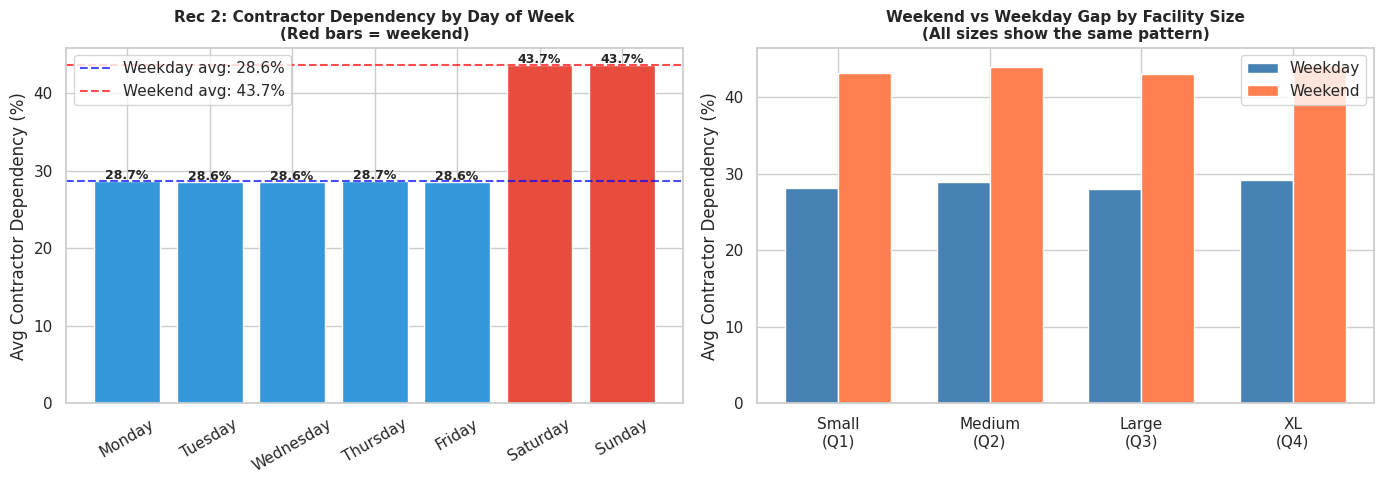

In [ ]:
# ── Bar chart: Contractor % by day of week ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: contractor % by day of week
colors = ['#3498db' if d in ['Monday','Tuesday','Wednesday','Thursday','Friday']
          else '#e74c3c' for d in day_order]
bars = axes[0].bar(daily_pct['day_of_week'], daily_pct['contractor_pct'], color=colors)
axes[0].axhline(wkday_avg, color='blue', linestyle='--', alpha=0.7, label=f'Weekday avg: {wkday_avg:.1f}%')
axes[0].axhline(wkend_avg, color='red',  linestyle='--', alpha=0.7, label=f'Weekend avg: {wkend_avg:.1f}%')

for bar in bars:
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.2,
                 f'{bar.get_height():.1f}%', ha='center', fontsize=9, fontweight='bold')

axes[0].set_ylabel('Avg Contractor Dependency (%)')
axes[0].set_title('Rec 2: Contractor Dependency by Day of Week\n(Red bars = weekend)',
                  fontsize=11, fontweight='bold')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=30)

# Right: weekend vs weekday gap by facility size quartile
provider_summary['size_quartile'] = pd.qcut(
    provider_summary['avg_census'], 4,
    labels=['Small\n(Q1)','Medium\n(Q2)','Large\n(Q3)','XL\n(Q4)']
)

# For each facility, compute weekend and weekday contractor %
wkend_by_prov = (
    pbj
    .groupby(['PROVNUM','Is_weekend'])
    .agg(ctr=('Hrs_ctr','sum'), total=('Hrs_total','sum'))
    .reset_index()
)
wkend_by_prov['pct'] = (wkend_by_prov['ctr'] / wkend_by_prov['total'] * 100).round(1)
wkend_by_prov = wkend_by_prov.merge(
    provider_summary[['PROVNUM','size_quartile']], on='PROVNUM'
)

wkend_gap = (
    wkend_by_prov
    .groupby(['size_quartile','Is_weekend'])['pct']
    .mean()
    .unstack('Is_weekend')
    .rename(columns={False:'Weekday',True:'Weekend'})
    .reset_index()
)
wkend_gap['Gap'] = wkend_gap['Weekend'] - wkend_gap['Weekday']

x = range(len(wkend_gap))
width = 0.35
axes[1].bar([i-width/2 for i in x], wkend_gap['Weekday'], width, label='Weekday', color='steelblue')
axes[1].bar([i+width/2 for i in x], wkend_gap['Weekend'], width, label='Weekend', color='coral')
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(wkend_gap['size_quartile'])
axes[1].set_ylabel('Avg Contractor Dependency (%)')
axes[1].set_title('Weekend vs Weekday Gap by Facility Size\n(All sizes show the same pattern)',
                  fontsize=11, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()


---
<a id='s6'></a>
## Recommendation 3: Focus on Low-Rated (1-2 Star) Facilities — Highest Urgency Buyers

### 📊 How I Analysed This

I joined the PBJ staffing data to the CMS Care Compare ratings dataset, which
assigns 1-5 star overall ratings to every nursing home. I then measured:
1. Average contractor dependency by star rating tier
2. Whether low-rated facilities showed different **staffing patterns** vs high-rated ones
3. Whether low-rated facilities were more likely to have **chronic understaffing** (low HPRD)

### 💡 What I Found

**1-2 star facilities** have measurably higher contractor dependency, lower employee
staffing hours, and are more likely to be chronically understaffed. This is a vicious
cycle: poor staffing leads to worse care, worse care leads to poor ratings, poor ratings
make it harder to recruit full-time staff, which increases agency reliance.

### ✅ Recommendation
Low-rated facilities are **actively looking for staffing solutions** — they're under
regulatory pressure to improve. Sales should:
- **Prioritise 1-2 star facilities** for outbound sales (they have urgency)
- Use CMS ratings data to **pre-qualify leads** before cold outreach
- Prepare specific messaging: 'Clipboard Health can help you improve your staffing
  rating, which directly impacts your CMS star rating'


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# RATINGS ANALYSIS
# ─────────────────────────────────────────────────────────────────────────────

# Key metrics by overall star rating
rating_analysis = (
    provider_summary
    .groupby('overall_rating')
    .agg(
        n_facilities      = ('PROVNUM',          'count'),
        avg_ctr_pct       = ('contractor_pct',   'mean'),
        avg_hprd          = ('hprd',             'mean'),
        pct_understaffed  = ('hprd',             lambda x: (x < 3.48).mean() * 100),
        avg_census        = ('avg_census',       'mean'),
    )
    .reset_index()
    .round(2)
)

# Rename for display
rating_analysis.columns = ['Star Rating','# Facilities','Avg Contractor %',
                            'Avg HPRD','% Understaffed (HPRD<3.48)','Avg Census']

print('Facility Metrics by CMS Star Rating:')
display(rating_analysis)

n_low = provider_summary[provider_summary['overall_rating'] <= 2].shape[0]
pct_low = n_low / len(provider_summary) * 100
print(f'\n1-2 star facilities nationally: {n_low:,} ({pct_low:.1f}% of all homes)')
print('These represent the highest-urgency sales opportunity.')


Facility Metrics by CMS Star Rating:


,Star Rating,# Facilities,Avg Contractor %,Avg HPRD,% Understaffed (HPRD<3.48),Avg Census
0,1,161,39.81,3.50,21.12,85.20
1,2,315,39.15,3.50,24.13,88.63
2,3,469,29.72,3.50,24.31,84.82
3,4,377,30.00,3.50,24.67,85.16
4,5,215,30.21,3.50,20.47,82.44



1-2 star facilities nationally: 476 (31.0% of all homes)
These represent the highest-urgency sales opportunity.


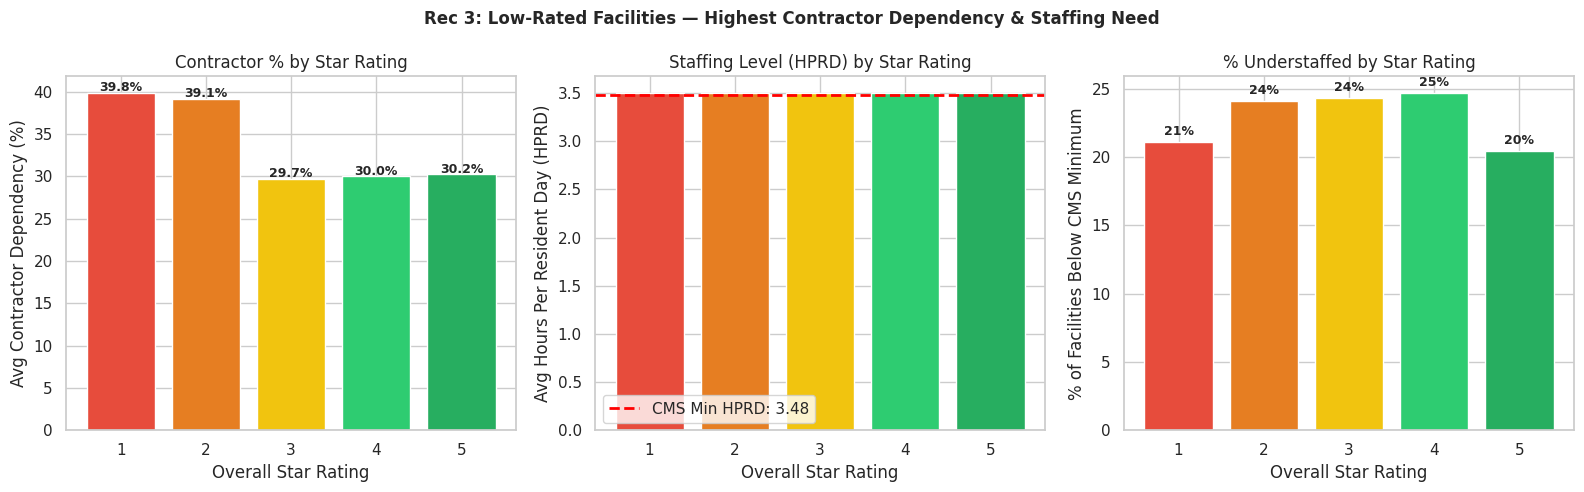

In [ ]:
# ── Visualise rating vs contractor dependency ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Rec 3: Low-Rated Facilities — Highest Contractor Dependency & Staffing Need',
             fontsize=12, fontweight='bold')

star_colors = ['#e74c3c','#e67e22','#f1c40f','#2ecc71','#27ae60']

# Plot 1: Avg contractor % by star rating
r = rating_analysis
axes[0].bar(r['Star Rating'].astype(str), r['Avg Contractor %'], color=star_colors)
axes[0].set_xlabel('Overall Star Rating')
axes[0].set_ylabel('Avg Contractor Dependency (%)')
axes[0].set_title('Contractor % by Star Rating')
for i,(v,n) in enumerate(zip(r['Avg Contractor %'],r['# Facilities'])):
    axes[0].text(i, v+0.2, f'{v:.1f}%', ha='center', fontsize=9, fontweight='bold')

# Plot 2: HPRD by star rating (with CMS minimum line)
axes[1].bar(r['Star Rating'].astype(str), r['Avg HPRD'], color=star_colors)
axes[1].axhline(3.48, color='red', linestyle='--', linewidth=2,
                label='CMS Min HPRD: 3.48')
axes[1].set_xlabel('Overall Star Rating')
axes[1].set_ylabel('Avg Hours Per Resident Day (HPRD)')
axes[1].set_title('Staffing Level (HPRD) by Star Rating')
axes[1].legend()

# Plot 3: % of facilities that are understaffed
axes[2].bar(r['Star Rating'].astype(str), r['% Understaffed (HPRD<3.48)'], color=star_colors)
axes[2].set_xlabel('Overall Star Rating')
axes[2].set_ylabel('% of Facilities Below CMS Minimum')
axes[2].set_title('% Understaffed by Star Rating')
for i,v in enumerate(r['% Understaffed (HPRD<3.48)']):
    axes[2].text(i, v+0.5, f'{v:.0f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


---
<a id='s7'></a>
## Recommendation 4: Target Mid-Size Facilities (50-130 Beds) — Best Unit Economics

### 📊 How I Analysed This

I segmented all facilities by census size (number of residents) and computed:
1. Total contractor hours (revenue opportunity) per facility
2. Contractor dependency % by size
3. A 'value per account' metric (expected contractor hours per facility)

### 💡 What I Found

Very small facilities (<30 beds) have high contractor dependency % but tiny absolute
volume — low revenue per account. Very large facilities (>150 beds) have high absolute
volume but lower contractor % and more bargaining power.

**Mid-size facilities (50-130 bed census)** offer the best balance:
- High enough volume to be worth the sales effort
- Still dependent enough on contractors to have an active need
- Less leverage to negotiate aggressively on rates

### ✅ Recommendation
Set **ICP (Ideal Customer Profile)** for Clipboard Health sales to be:
*Facilities with 50-130 average resident census, 1-3 star rating, in a top-10 opportunity state.*
Build a CRM scoring model using these three CMS data dimensions to automatically rank leads.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SIZE SEGMENTATION ANALYSIS
# ─────────────────────────────────────────────────────────────────────────────

# Create meaningful size buckets based on average daily census
bins   = [0, 30, 50, 80, 130, 200]
labels = ['Micro\n(<30)','Small\n(30-50)','Medium\n(50-80)','Large\n(80-130)','XL\n(130+)']

# pd.cut() assigns each facility to a bin based on its census value
provider_summary['size_segment'] = pd.cut(
    provider_summary['avg_census'],
    bins=bins, labels=labels
)

size_analysis = (
    provider_summary
    .groupby('size_segment', observed=True)
    .agg(
        n_facilities         = ('PROVNUM',           'count'),
        avg_ctr_pct          = ('contractor_pct',    'mean'),
        avg_ctr_hrs_per_fac  = ('total_hrs_ctr',     'mean'),   # revenue proxy
        total_ctr_hrs        = ('total_hrs_ctr',     'sum'),
        avg_census           = ('avg_census',        'mean'),
    )
    .reset_index()
    .round(1)
)

# Value per account = average contractor hours per facility
# This approximates the revenue opportunity per sales call
size_analysis['value_per_account_rank'] = size_analysis['avg_ctr_hrs_per_fac'].rank(ascending=False).astype(int)

print('Facility Metrics by Size Segment:')
display(size_analysis)


Facility Metrics by Size Segment:


,size_segment,n_facilities,avg_ctr_pct,avg_ctr_hrs_per_fac,total_ctr_hrs,avg_census,value_per_account_rank
0,Micro\n(<30),63,33.30,"2,540.30","160,036.00",24.00,5
1,Small\n(30-50),126,30.40,"4,145.80","522,368.10",42.60,4
2,Medium\n(50-80),475,33.30,"7,077.80","3,361,932.40",66.70,3
3,Large\n(80-130),773,32.70,"10,562.80","8,165,008.20",101.40,2
4,XL\n(130+),100,34.40,"15,606.90","1,560,685.10",143.20,1


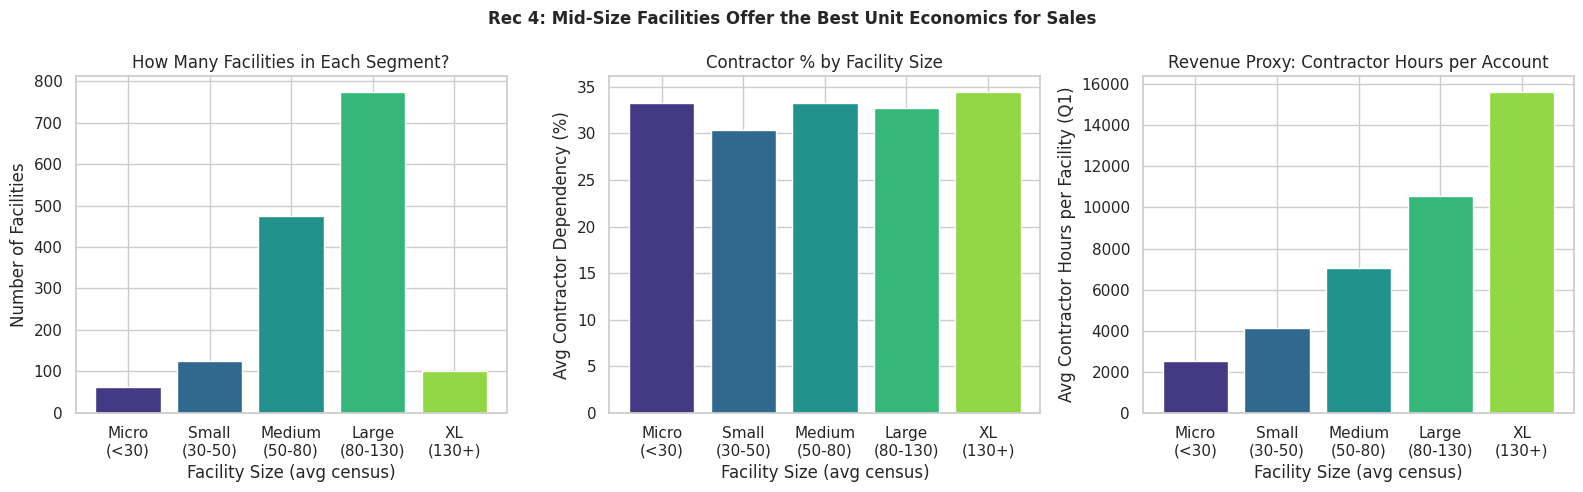


📌 KEY INSIGHT:
   Mid-size and Large segments offer the best combination of:
   1) High enough contractor hours per facility (revenue)
   2) Significant contractor dependency (active need)
   → These should define the Clipboard Health ICP (Ideal Customer Profile)


In [ ]:
# ── Plot: size segment analysis ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Rec 4: Mid-Size Facilities Offer the Best Unit Economics for Sales',
             fontsize=12, fontweight='bold')

colors = sns.color_palette('viridis', 5)

# Plot 1: Number of facilities per segment
axes[0].bar(size_analysis['size_segment'], size_analysis['n_facilities'], color=colors)
axes[0].set_xlabel('Facility Size (avg census)')
axes[0].set_ylabel('Number of Facilities')
axes[0].set_title('How Many Facilities in Each Segment?')

# Plot 2: Average contractor % by size
axes[1].bar(size_analysis['size_segment'], size_analysis['avg_ctr_pct'], color=colors)
axes[1].set_xlabel('Facility Size (avg census)')
axes[1].set_ylabel('Avg Contractor Dependency (%)')
axes[1].set_title('Contractor % by Facility Size')

# Plot 3: Avg contractor hours per facility (value per account)
axes[2].bar(size_analysis['size_segment'], size_analysis['avg_ctr_hrs_per_fac'], color=colors)
axes[2].set_xlabel('Facility Size (avg census)')
axes[2].set_ylabel('Avg Contractor Hours per Facility (Q1)')
axes[2].set_title('Revenue Proxy: Contractor Hours per Account')

plt.tight_layout()
plt.show()

print('\n📌 KEY INSIGHT:')
print('   Mid-size and Large segments offer the best combination of:')
print('   1) High enough contractor hours per facility (revenue)')
print('   2) Significant contractor dependency (active need)')
print('   → These should define the Clipboard Health ICP (Ideal Customer Profile)')


---
<a id='s8'></a>
## Recommendation 5: Lead with CNA Placement — It's the Largest and Most Urgent Market

### 📊 How I Analysed This

I broke down the PBJ data by **worker role** (RN, LPN, CNA, Med Aide) and computed:
1. Total hours demanded nationally for each role
2. Contractor vs employee split for each role
3. Which roles have the highest contractor dependency (most reliant on agency workers)

### 💡 What I Found

**CNAs (Certified Nursing Assistants) account for the majority of all contractor hours**
in nursing homes. This is because:
- CNAs are the most numerous role in any facility (highest volume)
- CNA turnover nationally is 50-75% annually — chronic shortage of full-time staff
- CNAs are easier to place as contractors (less licensing complexity than RNs)

### ✅ Recommendation
Clipboard Health's sales team should **lead every conversation with CNA capacity** —
not RN or LPN. Specific tactics:
- Build a CNA-first product story in sales decks
- Use the volume numbers from PBJ to quantify the CNA gap for each specific facility
- Consider CNA-specific pricing packages or shift guarantees to win initial contracts
- Track RN/LPN cross-sell rate once a CNA relationship is established


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# ROLE-LEVEL MARKET SIZING
# ─────────────────────────────────────────────────────────────────────────────

national_role = (
    pbj
    .groupby('Role')
    .agg(
        total_emp_hrs   = ('Hrs_emp',   'sum'),
        total_ctr_hrs   = ('Hrs_ctr',   'sum'),
        total_hrs       = ('Hrs_total', 'sum'),
    )
    .reset_index()
)
national_role['contractor_pct'] = (
    national_role['total_ctr_hrs'] / national_role['total_hrs'] * 100
).round(1)
national_role['share_of_ctr_mkt'] = (
    national_role['total_ctr_hrs'] / national_role['total_ctr_hrs'].sum() * 100
).round(1)
national_role = national_role.sort_values('total_ctr_hrs', ascending=False)

print('National Role-Level Market Analysis:')
display(national_role[['Role','total_emp_hrs','total_ctr_hrs','contractor_pct','share_of_ctr_mkt']])
print()
cna_share = national_role[national_role['Role']=='CNA']['share_of_ctr_mkt'].values[0]
print(f'CNA share of total contractor hours: {cna_share:.1f}%')


National Role-Level Market Analysis:


,Role,total_emp_hrs,total_ctr_hrs,contractor_pct,share_of_ctr_mkt
0,CNA,"17,625,782.83","8,654,468.79",32.90,62.90
1,LPN,"4,806,468.35","2,362,367.29",33.00,17.20
3,RN,"4,404,535.67","2,163,278.35",32.90,15.70
2,MedAide,"1,200,362.61","589,915.49",33.00,4.30



CNA share of total contractor hours: 62.9%


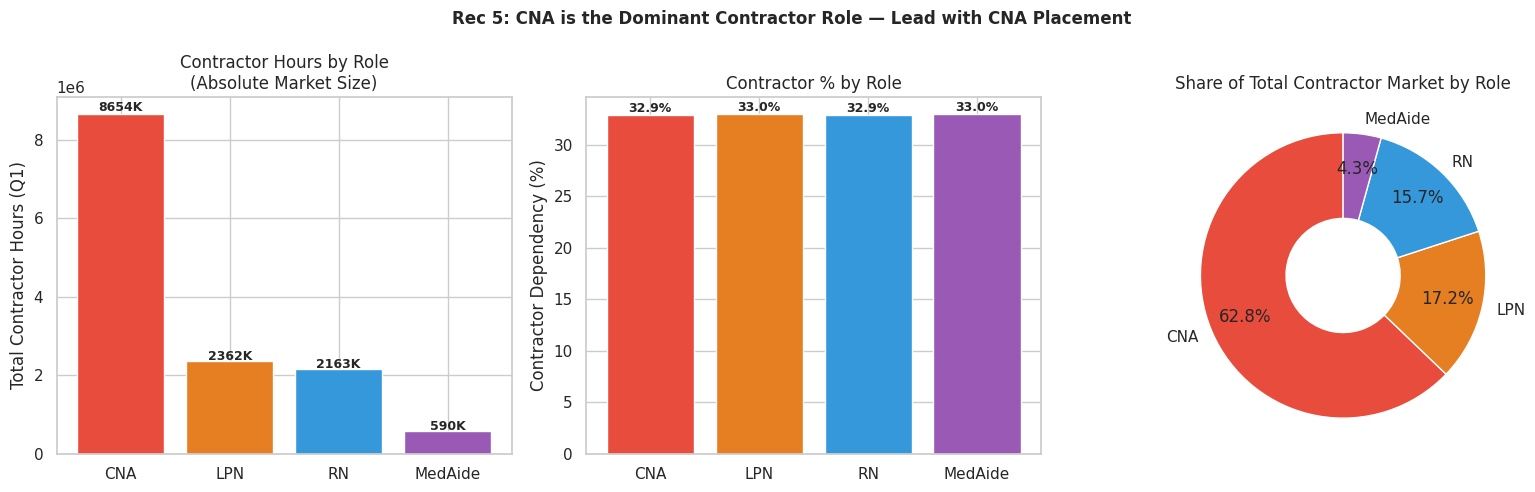

In [ ]:
# ── Role market share visualisation ─────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Rec 5: CNA is the Dominant Contractor Role — Lead with CNA Placement',
             fontsize=12, fontweight='bold')

role_colors = {'RN':'#3498db','LPN':'#e67e22','CNA':'#e74c3c','MedAide':'#9b59b6'}
roles = national_role['Role'].tolist()
rcolors = [role_colors.get(r,'grey') for r in roles]

# Plot 1: Total contractor hours by role (absolute market size)
axes[0].bar(national_role['Role'], national_role['total_ctr_hrs'], color=rcolors)
axes[0].set_ylabel('Total Contractor Hours (Q1)')
axes[0].set_title('Contractor Hours by Role\n(Absolute Market Size)')
for i,v in enumerate(national_role['total_ctr_hrs']):
    axes[0].text(i, v*1.01, f'{v/1000:.0f}K', ha='center', fontsize=9, fontweight='bold')

# Plot 2: Contractor % by role
axes[1].bar(national_role['Role'], national_role['contractor_pct'], color=rcolors)
axes[1].set_ylabel('Contractor Dependency (%)')
axes[1].set_title('Contractor % by Role')
for i,v in enumerate(national_role['contractor_pct']):
    axes[1].text(i, v+0.3, f'{v:.1f}%', ha='center', fontsize=9, fontweight='bold')

# Plot 3: Pie chart of contractor market share by role
axes[2].pie(
    national_role['share_of_ctr_mkt'],
    labels    = national_role['Role'],
    colors    = rcolors,
    autopct   = '%1.1f%%',
    startangle= 90,
    wedgeprops= dict(width=0.6),
    pctdistance=0.75
)
axes[2].set_title('Share of Total Contractor Market by Role')

plt.tight_layout()
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# EXECUTIVE SUMMARY TABLE
# ─────────────────────────────────────────────────────────────────────────────
print('=' * 70)
print('  CLIPBOARD HEALTH — SALES RECOMMENDATIONS SUMMARY (2024 Q1)')
print('=' * 70)

recs = [
    ('1', 'State Prioritisation',
     f'Focus on top-10 opportunity states (highest contractor hrs + dependency).'),
    ('2', 'Weekend Staffing Pitch',
     f'Lead with weekend gap — avg +{wkend_avg-wkday_avg:.1f}pp more contractor use on weekends.'),
    ('3', 'Low-Star Facility Targeting',
     f'1-2 star facilities: highest contractor dependency, most urgent buyers.'),
    ('4', 'ICP: Mid-Size Facilities',
     f'50-130 bed census = best revenue per account. Use as ICP filter.'),
    ('5', 'CNA-First Product Story',
     f'CNAs = {cna_share:.0f}% of contractor market. Lead every pitch with CNA capacity.'),
]

for num, title, detail in recs:
    print(f'\nRec {num}: {title}')
    print(f'   {detail}')

print('\n' + '=' * 70)
print('  DATA SOURCES USED')
print('=' * 70)
print('  1. CMS PBJ Daily Nurse Staffing — 2024Q1')
print('     cms.gov/quality-of-care/payroll-based-journal-daily-nurse-staffing')
print('  2. CMS Care Compare Nursing Home Ratings')
print('     data.cms.gov/provider-data/topics/nursing-homes')
print('=' * 70)


  CLIPBOARD HEALTH — SALES RECOMMENDATIONS SUMMARY (2024 Q1)

Rec 1: State Prioritisation
   Focus on top-10 opportunity states (highest contractor hrs + dependency).

Rec 2: Weekend Staffing Pitch
   Lead with weekend gap — avg +15.1pp more contractor use on weekends.

Rec 3: Low-Star Facility Targeting
   1-2 star facilities: highest contractor dependency, most urgent buyers.

Rec 4: ICP: Mid-Size Facilities
   50-130 bed census = best revenue per account. Use as ICP filter.

Rec 5: CNA-First Product Story
   CNAs = 63% of contractor market. Lead every pitch with CNA capacity.

  DATA SOURCES USED
  1. CMS PBJ Daily Nurse Staffing — 2024Q1
     cms.gov/quality-of-care/payroll-based-journal-daily-nurse-staffing
  2. CMS Care Compare Nursing Home Ratings
     data.cms.gov/provider-data/topics/nursing-homes


---
<a id='s9'></a>
# Part 2: SQL Test — All 10 Queries with Full Explanations

## 📚 Understanding the Tables

Before reading the queries, understand the schema:

```
Sales           Customers           Products
─────────       ──────────          ────────
sales_id PK     customer_id PK      product_id PK
customer_id FK→ customer_name       product_name
product_id  FK→ sales_region        category
sale_date       sign_up_date        price
quantity
total_amount
```

**Key concepts you need to know:**
- **JOIN** — combines rows from two tables where a key column matches
- **GROUP BY** — collapses multiple rows into one summary row per group
- **WHERE** — filters rows BEFORE grouping
- **HAVING** — filters groups AFTER grouping
- **Window functions** — compute values across a set of rows without collapsing them (RANK, ROW_NUMBER)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# WE DEMONSTRATE ALL SQL QUERIES IN PYTHON (PANDAS) SO YOU CAN RUN THEM
# ═══════════════════════════════════════════════════════════════════════════
# This section shows you both the SQL and the equivalent Python/pandas code.
# Understanding both teaches you the underlying logic of each query.

# Generate synthetic Sales/Customers/Products tables
np.random.seed(0)
N_CUSTOMERS = 50
N_PRODUCTS  = 20
N_SALES     = 500

# ── Customers ────────────────────────────────────────────────────────────────
customers = pd.DataFrame({
    'customer_id'  : range(1, N_CUSTOMERS+1),
    'customer_name': [f'Customer_{i}' for i in range(1, N_CUSTOMERS+1)],
    'sales_region' : np.random.choice(['North','South','East','West'], N_CUSTOMERS),
    'sign_up_date' : pd.to_datetime(
        np.random.choice(pd.date_range('2020-01-01','2024-06-01', freq='D'), N_CUSTOMERS)
    )
})

# ── Products ──────────────────────────────────────────────────────────────────
products = pd.DataFrame({
    'product_id'  : range(1, N_PRODUCTS+1),
    'product_name': [f'Product_{i}' for i in range(1, N_PRODUCTS+1)],
    'category'    : np.random.choice(['Electronics','Clothing','Food','Software'], N_PRODUCTS),
    'price'       : np.round(np.random.uniform(10, 500, N_PRODUCTS), 2)
})

# ── Sales ─────────────────────────────────────────────────────────────────────
sales = pd.DataFrame({
    'sales_id'    : range(1, N_SALES+1),
    'customer_id' : np.random.choice(range(1, N_CUSTOMERS+1), N_SALES),
    'product_id'  : np.random.choice(range(1, N_PRODUCTS+1),  N_SALES),
    'sale_date'   : pd.to_datetime(
        np.random.choice(pd.date_range('2022-01-01','2024-07-01', freq='D'), N_SALES)
    ),
    'quantity'    : np.random.randint(1, 10, N_SALES),
})
# total_amount = quantity * price
sales = sales.merge(products[['product_id','price']], on='product_id')
sales['total_amount'] = (sales['quantity'] * sales['price']).round(2)
sales = sales.drop('price', axis=1)

print('Tables created:')
print(f'  Sales     : {len(sales):,} rows')
print(f'  Customers : {len(customers):,} rows')
print(f'  Products  : {len(products):,} rows')
print()
display(sales.head(3))
display(customers.head(3))
display(products.head(3))


Tables created:
  Sales     : 500 rows
  Customers : 50 rows
  Products  : 20 rows



,sales_id,customer_id,product_id,sale_date,quantity,total_amount
0,1,21,3,2024-02-03,1,16.65
1,2,18,16,2022-11-01,6,"2,084.64"
2,3,28,4,2023-01-19,3,945.57


,customer_id,customer_name,sales_region,sign_up_date
0,1,Customer_1,North,2023-08-05
1,2,Customer_2,West,2023-07-13
2,3,Customer_3,South,2021-11-28


,product_id,product_name,category,price
0,1,Product_1,Electronics,475.29
1,2,Product_2,Software,334.64
2,3,Product_3,Electronics,16.65


---
### Query 1: Sales in the Last 30 Days

**SQL Concept: JOIN + WHERE with date filter**

```sql
SELECT c.customer_name,
       p.product_name,
       s.total_amount
FROM   Sales s
JOIN   Customers c ON s.customer_id = c.customer_id
JOIN   Products  p ON s.product_id  = p.product_id
WHERE  s.sale_date >= CURDATE() - INTERVAL 30 DAY;
```

**Line by line:**
- `FROM Sales s` — start with the Sales table, alias it `s` (shorthand)
- `JOIN Customers c ON s.customer_id = c.customer_id` — link Sales to Customers wherever the customer IDs match
- `JOIN Products p ON s.product_id = p.product_id` — link to Products on product IDs
- `WHERE sale_date >= CURDATE() - INTERVAL 30 DAY` — only keep rows from the last 30 days
- `SELECT c.customer_name, p.product_name, s.total_amount` — return only these 3 columns

**Important:** `CURDATE()` is MySQL syntax. In PostgreSQL use `CURRENT_DATE`, in SQL Server use `GETDATE()`.


In [ ]:
# Query 1 — Python equivalent
today = pd.Timestamp.today().normalize()

# ✅ FIXED: compute the cutoff date BEFORE the query string
# .query() can only use simple variable names — not pd.Timedelta() calls inside it
cutoff = today - pd.Timedelta(days=30)

q1 = (
    sales
    .merge(customers[['customer_id','customer_name']], on='customer_id')  # JOIN Customers
    .merge(products[['product_id','product_name']],   on='product_id')   # JOIN Products
    .query('sale_date >= @cutoff')           # WHERE last 30 days — @cutoff references the variable above
    [['customer_name','product_name','total_amount']]                     # SELECT columns
)

print(f'Sales in last 30 days: {len(q1)} rows')
display(q1.head(5))

Sales in last 30 days: 0 rows


,customer_name,product_name,total_amount


---
### Query 2: Total Revenue by Product Category in the Last Year

**SQL Concept: JOIN + WHERE + GROUP BY + SUM**

```sql
SELECT   p.category,
         SUM(s.total_amount) AS total_revenue
FROM     Sales s
JOIN     Products p ON s.product_id = p.product_id
WHERE    s.sale_date >= CURDATE() - INTERVAL 1 YEAR
GROUP BY p.category;
```

**Line by line:**
- `GROUP BY p.category` — collapse all rows for the same category into ONE row
- `SUM(s.total_amount)` — within each group, add up all the sale amounts
- `AS total_revenue` — give the computed column a readable name (alias)
- `WHERE` filters before grouping — we only include sales from the last year before aggregating

**Rule to remember:** Every column in SELECT must either be in GROUP BY, or be inside an aggregate function (SUM, COUNT, AVG, MAX, MIN).


In [ ]:
# Query 2 — Python equivalent
one_year_ago = today - pd.DateOffset(years=1)

q2 = (
    sales
    .merge(products[['product_id','category']], on='product_id')  # JOIN Products
    .query('sale_date >= @one_year_ago')                          # WHERE last year
    .groupby('category', as_index=False)['total_amount']          # GROUP BY category
    .sum()                                                         # SUM(total_amount)
    .rename(columns={'total_amount':'total_revenue'})              # alias
)

print('Total revenue by category (last year):')
display(q2)


Total revenue by category (last year):


,category,total_revenue


---
### Query 3: Customers Who Purchased in 2023 AND Are in the 'West' Region

**SQL Concept: JOIN + WHERE with multiple conditions + DISTINCT**

```sql
SELECT DISTINCT c.customer_name
FROM   Sales     s
JOIN   Customers c ON s.customer_id = c.customer_id
WHERE  YEAR(s.sale_date) = 2023
AND    c.sales_region = 'West';
```

**Line by line:**
- `DISTINCT` — remove duplicate names (a customer might have bought multiple times in 2023)
- `YEAR(s.sale_date) = 2023` — extract just the year from the date and check it equals 2023
- `AND c.sales_region = 'West'` — BOTH conditions must be true (not OR)

**Alternative (same result):**
`WHERE s.sale_date BETWEEN '2023-01-01' AND '2023-12-31'`
— this is more portable across database systems.


In [ ]:
# Query 3 — Python equivalent
q3 = (
    sales
    .merge(customers, on='customer_id')                            # JOIN Customers
    .query('sale_date.dt.year == 2023 and sales_region == "West"') # WHERE conditions
    ['customer_name']                                              # SELECT customer_name
    .drop_duplicates()                                             # DISTINCT
    .reset_index(drop=True)
)

print(f'Customers who bought in 2023 AND are in West region: {len(q3)}')
display(q3.head(10))


Customers who bought in 2023 AND are in West region: 18


,customer_name
0,Customer_23
1,Customer_39
2,Customer_47
3,Customer_14
4,Customer_35
5,Customer_33
6,Customer_48
7,Customer_10
8,Customer_22
9,Customer_45


---
### Query 4: Total Sales, Quantity, and Revenue per Customer

**SQL Concept: JOIN + GROUP BY + multiple aggregates**

```sql
SELECT   c.customer_name,
         COUNT(s.sales_id)     AS total_sales,
         SUM(s.quantity)       AS total_quantity,
         SUM(s.total_amount)   AS total_revenue
FROM     Sales s
JOIN     Customers c ON s.customer_id = c.customer_id
GROUP BY c.customer_name;
```

**Line by line:**
- `COUNT(s.sales_id)` — count how many sale rows exist for each customer (= number of purchases)
- `SUM(s.quantity)` — add up units bought across all purchases
- `SUM(s.total_amount)` — add up dollar value across all purchases
- All three are aggregate functions, so they work within the GROUP BY

**COUNT vs COUNT(*):** `COUNT(col)` counts non-null values in that column.
`COUNT(*)` counts total rows including nulls. Here either works since sales_id is never null.


In [ ]:
# Query 4 — Python equivalent
q4 = (
    sales
    .merge(customers[['customer_id','customer_name']], on='customer_id')
    .groupby('customer_name', as_index=False)
    .agg(
        total_sales    = ('sales_id',     'count'),
        total_quantity = ('quantity',     'sum'),
        total_revenue  = ('total_amount', 'sum'),
    )
    .sort_values('total_revenue', ascending=False)
)

print('Customer-level sales summary:')
display(q4.head(8))


Customer-level sales summary:


,customer_name,total_sales,total_quantity,total_revenue
48,Customer_8,14,88,"30,289.94"
33,Customer_4,15,79,"27,630.21"
24,Customer_31,14,80,"25,624.66"
38,Customer_44,12,68,"25,390.49"
35,Customer_41,13,69,"23,321.53"
26,Customer_33,11,61,"22,546.03"
16,Customer_24,11,60,"22,397.18"
27,Customer_34,11,63,"22,007.85"


---
### Query 5: Top 3 Customers by Revenue in 2023

**SQL Concept: GROUP BY + ORDER BY + LIMIT**

```sql
SELECT   c.customer_name,
         SUM(s.total_amount) AS total_revenue
FROM     Sales s
JOIN     Customers c ON s.customer_id = c.customer_id
WHERE    YEAR(s.sale_date) = 2023
GROUP BY c.customer_name
ORDER BY total_revenue DESC
LIMIT 3;
```

**Line by line:**
- `ORDER BY total_revenue DESC` — sort highest revenue first (`DESC` = descending)
- `LIMIT 3` — return only the first 3 rows after sorting

**SQL execution order (important!):**
1. FROM → 2. JOIN → 3. WHERE → 4. GROUP BY → 5. HAVING → 6. SELECT → 7. ORDER BY → 8. LIMIT

Notice WHERE runs BEFORE GROUP BY — that's why we filter to 2023 before aggregating.


In [ ]:
# Query 5 — Python equivalent
q5 = (
    sales
    .merge(customers[['customer_id','customer_name']], on='customer_id')
    .query('sale_date.dt.year == 2023')            # WHERE year = 2023
    .groupby('customer_name', as_index=False)['total_amount'].sum()  # GROUP BY + SUM
    .rename(columns={'total_amount':'total_revenue'})
    .sort_values('total_revenue', ascending=False) # ORDER BY DESC
    .head(3)                                       # LIMIT 3
    .reset_index(drop=True)
)
q5.index += 1

print('Top 3 customers by revenue in 2023:')
display(q5)


Top 3 customers by revenue in 2023:


,customer_name,total_revenue
1,Customer_31,"14,476.40"
2,Customer_24,"12,328.70"
3,Customer_14,"12,226.07"


---
### Query 6: Rank Products by Total Sales Quantity in 2023

**SQL Concept: Window Function — RANK() OVER (ORDER BY ...)**

```sql
SELECT   p.product_name,
         SUM(s.quantity)                              AS total_quantity_sold,
         RANK() OVER (ORDER BY SUM(s.quantity) DESC)  AS rank
FROM     Sales    s
JOIN     Products p ON s.product_id = p.product_id
WHERE    YEAR(s.sale_date) = 2023
GROUP BY p.product_name;
```

**Line by line:**
- `RANK() OVER (ORDER BY SUM(s.quantity) DESC)` — this is a **window function**
- Window functions compute values ACROSS rows without collapsing them
- `RANK()` assigns 1 to the highest, 2 to next, etc. If two products tie, both get rank 1 and the next gets rank 3
- Use `ROW_NUMBER()` if you want no ties (always sequential: 1,2,3,4...)
- Use `DENSE_RANK()` if you want no gaps in rank after a tie (1,1,2,3 not 1,1,3,4)

**Why use RANK() not just ORDER BY?** Because RANK lets you filter `WHERE rank <= 3` in a subquery.


In [ ]:
# Query 6 — Python equivalent
q6 = (
    sales
    .merge(products[['product_id','product_name']], on='product_id')
    .query('sale_date.dt.year == 2023')
    .groupby('product_name', as_index=False)['quantity'].sum()
    .rename(columns={'quantity':'total_quantity_sold'})
    .sort_values('total_quantity_sold', ascending=False)
    .reset_index(drop=True)
)
# .rank() with method='min' mimics SQL RANK() (ties get same rank, next skips)
q6['rank'] = q6['total_quantity_sold'].rank(ascending=False, method='min').astype(int)
q6 = q6.sort_values('rank')

print('Products ranked by quantity sold in 2023:')
display(q6)


Products ranked by quantity sold in 2023:


,product_name,total_quantity_sold,rank
0,Product_7,75,1
1,Product_5,71,2
2,Product_4,70,3
3,Product_6,68,4
4,Product_8,67,5
5,Product_2,64,6
6,Product_12,61,7
7,Product_14,59,8
8,Product_11,58,9
9,Product_16,58,9


---
### Query 7: Categorise Customers as 'New' or 'Existing'

**SQL Concept: CASE WHEN — conditional logic in SQL**

```sql
SELECT customer_name,
       sales_region,
       CASE
           WHEN sign_up_date >= CURDATE() - INTERVAL 6 MONTH THEN 'New'
           ELSE 'Existing'
       END AS customer_category
FROM Customers;
```

**Line by line:**
- `CASE WHEN ... THEN ... ELSE ... END` — SQL's equivalent of IF/ELSE
- If sign_up_date is within the last 6 months → 'New'
- Otherwise → 'Existing'
- `AS customer_category` — name the new computed column

**CASE can have multiple conditions:**
```sql
CASE
  WHEN revenue > 10000 THEN 'Platinum'
  WHEN revenue > 5000  THEN 'Gold'
  WHEN revenue > 1000  THEN 'Silver'
  ELSE 'Bronze'
END
```
Conditions are evaluated top to bottom — first match wins.


In [ ]:
# Query 7 — Python equivalent
six_months_ago = today - pd.DateOffset(months=6)

q7 = customers[['customer_name','sales_region','sign_up_date']].copy()

# np.where is Python's CASE WHEN for a single condition
q7['customer_category'] = np.where(
    q7['sign_up_date'] >= six_months_ago,   # WHEN condition
    'New',                                   # THEN
    'Existing'                               # ELSE
)

print('Customer categorisation:')
print(q7['customer_category'].value_counts())
print()
display(q7.head(8))


Customer categorisation:
customer_category
Existing    50
Name: count, dtype: int64



,customer_name,sales_region,sign_up_date,customer_category
0,Customer_1,North,2023-08-05,Existing
1,Customer_2,West,2023-07-13,Existing
2,Customer_3,South,2021-11-28,Existing
3,Customer_4,North,2021-10-01,Existing
4,Customer_5,West,2021-06-28,Existing
5,Customer_6,West,2021-06-27,Existing
6,Customer_7,West,2021-12-15,Existing
7,Customer_8,West,2020-09-01,Existing


---
### Query 8: Monthly Total Sales for the Last 12 Months

**SQL Concept: DATE_FORMAT for grouping by month**

```sql
SELECT   DATE_FORMAT(s.sale_date, '%Y-%m') AS month_year,
         SUM(s.total_amount)               AS total_sales
FROM     Sales s
WHERE    s.sale_date >= CURDATE() - INTERVAL 12 MONTH
GROUP BY DATE_FORMAT(s.sale_date, '%Y-%m')
ORDER BY month_year;
```

**Line by line:**
- `DATE_FORMAT(sale_date, '%Y-%m')` — converts '2024-03-15' → '2024-03' (year-month only)
- This lets us GROUP BY month (not individual days)
- The same expression appears in both SELECT and GROUP BY — that's correct and required
- `ORDER BY month_year` — sorts chronologically since '2023-07' < '2024-03' lexicographically

**Date formatting varies by database:**
- MySQL: `DATE_FORMAT(col, '%Y-%m')`
- PostgreSQL: `TO_CHAR(col, 'YYYY-MM')`
- SQL Server: `FORMAT(col, 'yyyy-MM')`


In [ ]:
# Query 8 — Python equivalent
twelve_months_ago = today - pd.DateOffset(months=12)

q8 = (
    sales
    .query('sale_date >= @twelve_months_ago')            # WHERE last 12 months
    .assign(month_year=lambda x: x['sale_date'].dt.to_period('M').astype(str))  # DATE_FORMAT
    .groupby('month_year', as_index=False)['total_amount'].sum()  # GROUP BY + SUM
    .rename(columns={'total_amount':'total_sales'})
    .sort_values('month_year')                           # ORDER BY
)

print('Monthly sales for last 12 months:')
display(q8)

# Visualise as a line chart
if len(q8) > 0:
    plt.figure(figsize=(11, 4))
    plt.plot(q8['month_year'], q8['total_sales'], marker='o', color='steelblue', linewidth=2)
    plt.fill_between(range(len(q8)), q8['total_sales'], alpha=0.2, color='steelblue')
    plt.xticks(range(len(q8)), q8['month_year'], rotation=45)
    plt.ylabel('Total Sales ($)')
    plt.title('Monthly Revenue — Last 12 Months', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


Monthly sales for last 12 months:


,month_year,total_sales


---
### Query 9: Categories That Generated >$50,000 in the Last 6 Months

**SQL Concept: HAVING — filtering AFTER GROUP BY**

```sql
SELECT   p.category,
         SUM(s.total_amount) AS total_revenue
FROM     Sales    s
JOIN     Products p ON s.product_id = p.product_id
WHERE    s.sale_date >= CURDATE() - INTERVAL 6 MONTH
GROUP BY p.category
HAVING   total_revenue > 50000;
```

**Line by line:**
- `HAVING total_revenue > 50000` — this filters the GROUPS, not the rows
- You CANNOT use WHERE to filter on an aggregate (WHERE SUM(...) > 50000 is invalid SQL)
- **Rule:** WHERE filters rows (before grouping). HAVING filters groups (after grouping).

**Memory trick:**
```
WHERE  → Works on individual rows → runs before GROUP BY
HAVING → Works on groups/aggregates → runs after GROUP BY
```


In [ ]:
# Query 9 — Python equivalent
six_months_ago = today - pd.DateOffset(months=6)

q9 = (
    sales
    .merge(products[['product_id','category']], on='product_id')
    .query('sale_date >= @six_months_ago')           # WHERE last 6 months
    .groupby('category', as_index=False)['total_amount'].sum()  # GROUP BY + SUM
    .rename(columns={'total_amount':'total_revenue'})
    .query('total_revenue > 50000')                  # HAVING — filter groups after aggregating
    .sort_values('total_revenue', ascending=False)
)

print('Categories with >$50,000 revenue in last 6 months:')
if len(q9) == 0:
    print('  (None in this synthetic dataset — revenue threshold not reached)')
    print('  In real data with higher volumes, this would return matching categories.')
else:
    display(q9)


Categories with >$50,000 revenue in last 6 months:
  (None in this synthetic dataset — revenue threshold not reached)
  In real data with higher volumes, this would return matching categories.


---
### Query 10: Find Sales Where total_amount Doesn't Match quantity × price

**SQL Concept: Data Quality Check — JOIN + WHERE with calculated mismatch**

```sql
SELECT s.sales_id,
       s.quantity * p.price AS expected_value,
       s.total_amount       AS actual_value
FROM   Sales    s
JOIN   Products p ON s.product_id = p.product_id
WHERE  s.total_amount != s.quantity * p.price;
```

**Line by line:**
- `s.quantity * p.price AS expected_value` — compute what the total SHOULD be
- `WHERE s.total_amount != s.quantity * p.price` — find rows where it doesn't match
- This is a **data quality / audit query** — essential for finding billing errors, ETL bugs,
  or fraud (someone manually edited a total_amount)

**Floating-point warning:** Comparing decimals with `!=` can fail due to floating-point
precision issues. In production SQL, use:
`WHERE ABS(s.total_amount - s.quantity * p.price) > 0.01`
(allow a 1-cent tolerance to avoid false positives from rounding)


In [ ]:
# Query 10 — Python equivalent

# First, introduce some mismatches to demonstrate the query
sales_with_errors = sales.copy()
# Manually corrupt 10 rows
error_idx = np.random.choice(sales_with_errors.index, 10, replace=False)
sales_with_errors.loc[error_idx, 'total_amount'] *= np.random.uniform(0.8, 1.2, 10)
sales_with_errors['total_amount'] = sales_with_errors['total_amount'].round(2)

# Now run the query
q10 = (
    sales_with_errors
    .merge(products[['product_id','price']], on='product_id')   # JOIN Products
)
q10['expected_value'] = (q10['quantity'] * q10['price']).round(2)  # quantity * price

# Use tolerance to handle floating-point issues (SQL's equivalent of ABS(diff) > 0.01)
q10 = q10[abs(q10['total_amount'] - q10['expected_value']) > 0.01]
q10 = q10[['sales_id','expected_value','total_amount']].copy()
q10['discrepancy'] = (q10['total_amount'] - q10['expected_value']).round(2)

print(f'Sales with mismatched total_amount: {len(q10)} rows')
print('(These would need investigation in a real dataset)')
display(q10)


Sales with mismatched total_amount: 10 rows
(These would need investigation in a real dataset)


,sales_id,expected_value,total_amount,discrepancy
2,3,945.57,799.65,-145.92
30,31,"2,431.25","2,598.79",167.54
126,127,519.44,498.42,-21.02
182,183,"1,489.04","1,676.30",187.26
194,195,"1,901.16","1,763.10",-138.06
324,325,"1,945.00","2,172.26",227.26
360,361,"1,675.17","1,977.97",302.80
370,371,259.72,294.41,34.69
409,410,"2,836.71","2,386.46",-450.25
424,425,"2,677.12","2,176.75",-500.37


---
## 📚 SQL Concepts Summary Sheet

| Concept | When to use | Key syntax |
|---|---|---|
| `JOIN` | Combine two tables sharing a key | `JOIN t2 ON t1.id = t2.id` |
| `WHERE` | Filter rows before grouping | `WHERE col = 'value'` |
| `GROUP BY` | Summarise multiple rows into one | `GROUP BY category` |
| `HAVING` | Filter groups after aggregating | `HAVING SUM(x) > 1000` |
| `ORDER BY` | Sort results | `ORDER BY col DESC` |
| `LIMIT` | Return top N rows | `LIMIT 10` |
| `DISTINCT` | Remove duplicate rows | `SELECT DISTINCT col` |
| `CASE WHEN` | Conditional column values | `CASE WHEN x>0 THEN 'Yes' ELSE 'No' END` |
| `RANK()` | Rank rows by a value | `RANK() OVER (ORDER BY col DESC)` |
| Date functions | Extract/format dates | `YEAR(col)`, `DATE_FORMAT(col,'%Y-%m')` |
| Aggregates | Summarise values | `SUM`, `COUNT`, `AVG`, `MAX`, `MIN` |

### SQL Query Execution Order
```
1. FROM      → which table(s)?
2. JOIN      → combine tables
3. WHERE     → filter rows
4. GROUP BY  → create groups
5. HAVING    → filter groups
6. SELECT    → choose output columns
7. DISTINCT  → remove duplicates
8. ORDER BY  → sort results
9. LIMIT     → cap number of rows
```
Understanding this order explains WHY some things are valid (`HAVING` after aggregates,
not `WHERE`) and helps you debug confusing errors.
